In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip '/content/drive/MyDrive/breast.zip' -d breast

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2001_class0.png  
  inflating: breast/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y2251_class0.png  
  inflat

In [ ]:
''' If you need to run this notebook on colab and download dataset you need to run those
commands after downloading your API Kaggle.json file
! pip install -q kaggle
from google.colab import files
files.upload()
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
! kaggle competitions download -c 'Breast Histopathology Images'
!kaggle datasets download -d paultimothymooney/breast-histopathology-images -p /content/My_directory/ --unzip'''

" If you need to run this notebook on colab and download dataset you need to run those\ncommands after downloading your API Kaggle.json file\n! pip install -q kaggle\nfrom google.colab import files\nfiles.upload()\n!rm -r ~/.kaggle\n!mkdir ~/.kaggle\n!mv ./kaggle.json ~/.kaggle/\n!chmod 600 ~/.kaggle/kaggle.json\n!kaggle datasets list\n! kaggle competitions download -c 'Breast Histopathology Images'\n!kaggle datasets download -d paultimothymooney/breast-histopathology-images -p /content/My_directory/ --unzip"

# About our data :
- Invasive Ductal Carcinoma (IDC) is the most common subtype of all breast cancers. To assign an aggressiveness grade to a whole mount sample, pathologists typically focus on the regions which contain the IDC. As a result, one of the common pre-processing steps for automatic aggressiveness grading is to delineate the exact regions of IDC inside of a whole mount slide.
- Breast cancer is the most common form of cancer in women, and invasive ductal carcinoma (IDC) is the most common form of breast cancer. Accurately identifying and categorizing breast cancer subtypes is an important clinical task, and automated methods can be used to save time and reduce error.
- In this note book we will try to identify if the patient has IDC or not by using CNN 

# Import libraries

In [3]:
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import keras.utils as image
%matplotlib inline
import seaborn as sns
import cv2 
import glob
import random
from os import listdir
import tensorflow.compat.v2 as tf
tf.keras.preprocessing.image.load_img

from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD

# Read our data

In [4]:
breast_img = glob.glob('/content/breast/IDC_regular_ps50_idx5/**/*.png', recursive = True)

for imgname in breast_img[:3]:
    print(imgname)

/content/breast/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2901_y551_class1.png
/content/breast/IDC_regular_ps50_idx5/9255/1/9255_idx5_x3151_y751_class1.png
/content/breast/IDC_regular_ps50_idx5/9255/1/9255_idx5_x2751_y401_class1.png


In [5]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)
    
    elif img[-5] == '1' :
        P_IDC.append(img)

- We want split our data to positive and negative IDC
- Each patch’s file name is in specific format :
     - example :10253idx5x1351y1101class0.png 

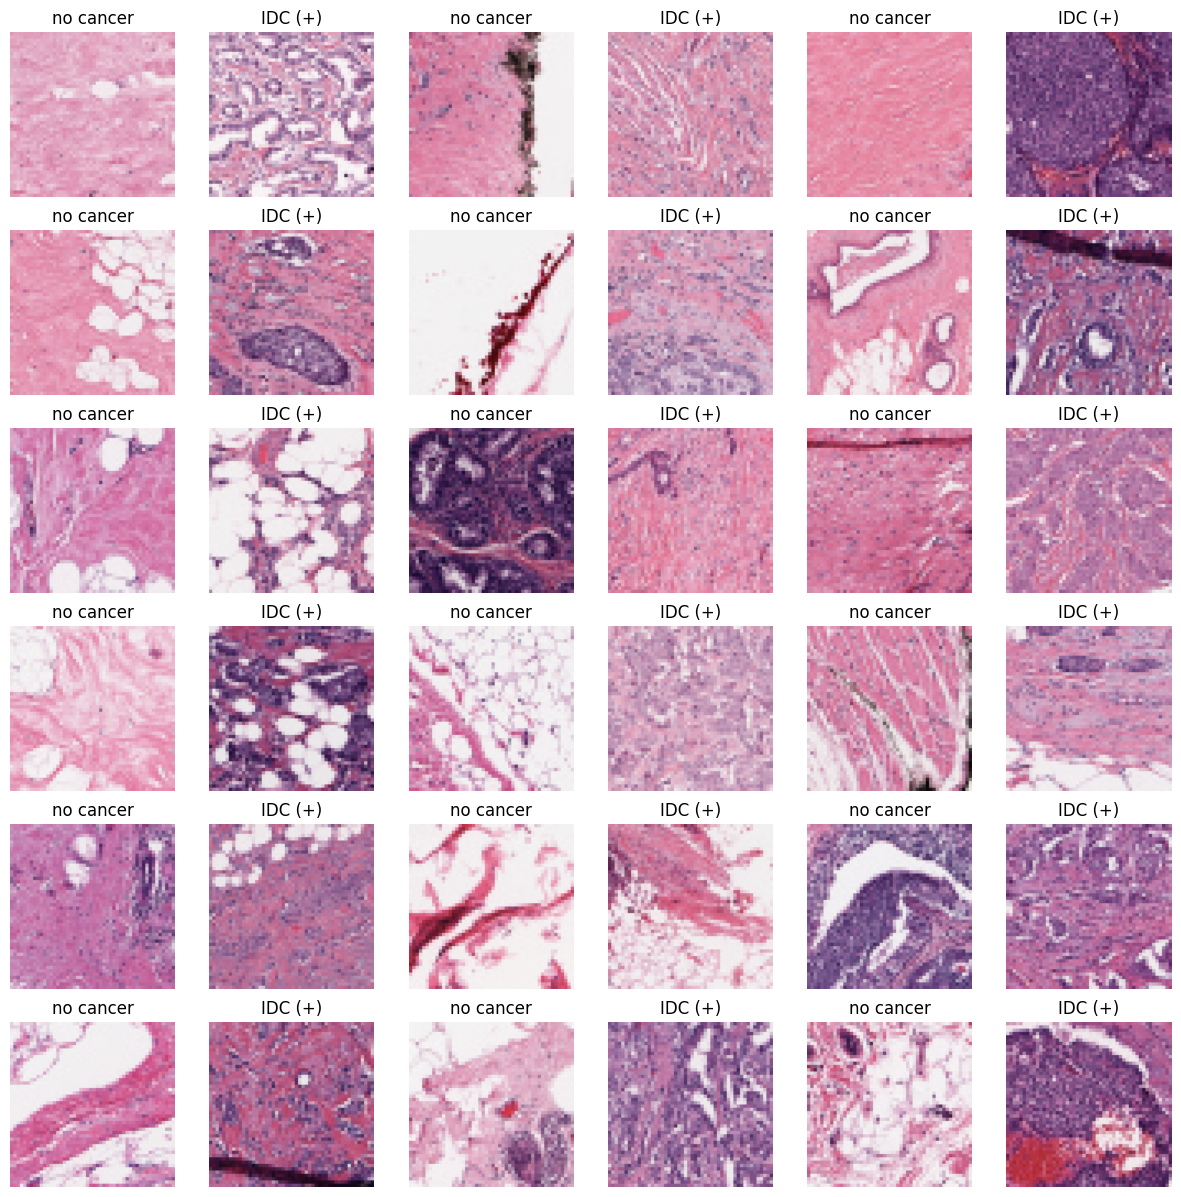

In [6]:
#from keras.preprocessing import image
import keras.utils as image

plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:
    
        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        #img = image.load_img((N_IDC[num]), target_size=(150,150))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:
    
        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)
        
        plt.subplot(6, 6, 2*s)
        plt.axis('off')        
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

# Handling images

In [7]:
non_img_arr = []
can_img_arr = []

for img in N_IDC:
        
    n_img = cv2.imread(img, cv2.IMREAD_COLOR)
    n_img_size = cv2.resize(n_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    non_img_arr.append([n_img_size, 0])
    
for img in P_IDC:
    c_img = cv2.imread(img, cv2.IMREAD_COLOR)
    c_img_size = cv2.resize(c_img, (50, 50), interpolation = cv2.INTER_LINEAR)
    can_img_arr.append([c_img_size, 1])

 **Because we have implalanced dataset we will take by hand more cancer images which will increase the accuracy of recall.**

In [8]:
print(len(can_img_arr))
can_img_arr2=can_img_arr[0:50000]
non_img_arr2=non_img_arr[0:50000]
print(len(can_img_arr2))
print(len(non_img_arr2))

78786
50000
50000


In [9]:
X = []
y = []

breast_img_arr = np.concatenate((non_img_arr2, can_img_arr2))
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
    X.append(feature)
    y.append(label)
    
X = np.array(X)
y = np.array(y)

print(len(y))

100000


- Identify labels [y] and images [X] 

Total number of images: 100000
Number of IDC(-) Images: 84699
Number of IDC(+) Images: 15301
Image shape (Width, Height, Channels): (50, 50, 3)


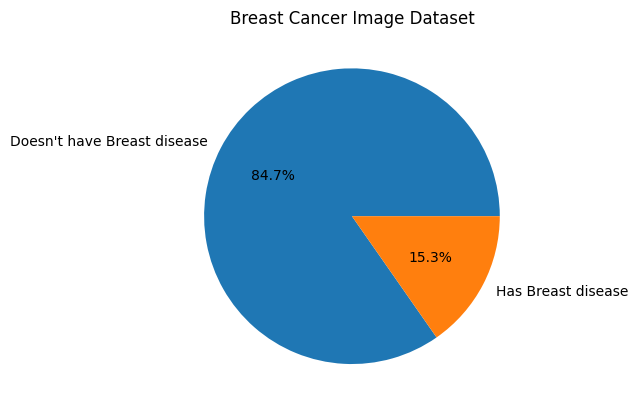

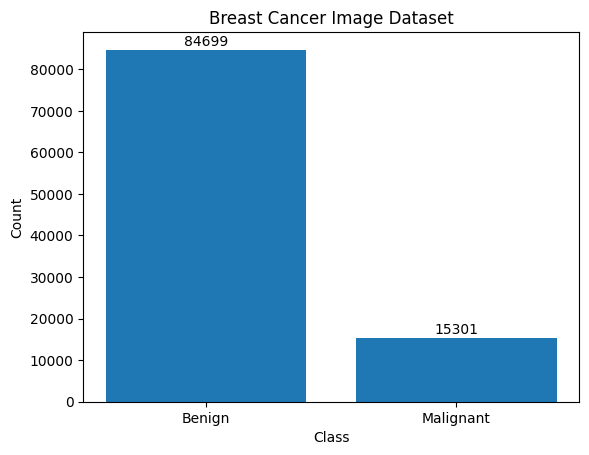

In [ ]:
import os
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

benign_count = np.sum(y==0)
malignant_count =  np.sum(y==1)

counts = [benign_count, malignant_count]
labels = ['Doesn\'t have Breast disease', 'Has Breast disease']

plt.pie(counts, labels=labels, autopct='%1.1f%%')
# plt.xlabel('Class')
# plt.ylabel('Count')
plt.title('Breast Cancer Image Dataset')
plt.show()

counts = [benign_count, malignant_count]
labels = ['Benign', 'Malignant']

plt.bar(labels, counts)
plt.title('Breast Cancer Image Dataset')
plt.xlabel('Class')
plt.ylabel('Count')

for i, v in enumerate(counts):
    plt.text(i, v+1000, str(v), ha='center')

plt.show()

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.3)

from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train, num_classes = 2)
Y_test = to_categorical(Y_test, num_classes = 2)

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (70000, 50, 50, 3)
Testing Data Shape: (30000, 50, 50, 3)


In [11]:
# Reduce Sample Size for allocating memory Problems in kaggle 

X_train = X_train[0:50000] 
Y_train = Y_train[0:50000] 
X_test = X_test[0:30000] 
Y_test = Y_test[0:30000] 

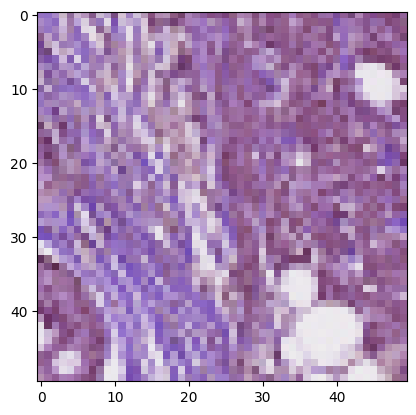

In [12]:
plt.imshow(X_train[0])

In [13]:
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools

# Buliding CNN architecture

In [ ]:
# 1. Исходная структура
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(50, 50, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [59]:
# 2. Сокращенная структура
early_stop=EarlyStopping(monitor='val_loss',patience=5)
model = Sequential()
model.add(Conv2D(4, (25, 25), activation='relu', strides = (12, 12), use_bias = False, trainable = False, padding='same', input_shape=(50, 50, 3)))
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.3))
model.add(Dense(24, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(2, activation='softmax'))

In [50]:
!pip install widelearning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
def txt_kernel_rgb(k1, k2, k3): 
 
	f1 = open(k1, 'r')
	f2 = open(k2, 'r')
	f3 = open(k3, 'r')
	
	w1 = []

	for i in f1:
		w1.append(i.strip().split(','))

	for j in w1:
		j.pop()

	for ii in w1:
		for i1, elem in enumerate(ii):
			ii[i1] = [[int(elem)]]

	w2 = []

	for i in f2:
		w2.append(i.strip().split(','))

	for j in w2:
		j.pop()

	for ii in w2:
		for i1, elem in enumerate(ii):
			ii[i1] = [int(elem)]

	for i in range(len(w1[0])):
		for j in range(len(w1[0])):
			w1[i][j].append(w2[i][j])

	w3 = []

	for i in f3:
		w3.append(i.strip().split(','))

	for j in w3:
		j.pop()

	for ii in w3:
		for i1, elem in enumerate(ii):
			ii[i1] = [int(elem)]

	for i in range(len(w1[0])):
		for j in range(len(w1[0])):
			w1[i][j].append(w3[i][j])
			
	return w1

#weights1 = txt_kernel_rgb('k1.txt', 'k2.txt', 'k3.txt')

def add_kernel_rgb(k1, k2, k3, w):

	f1 = open(k1, 'r')
	f2 = open(k2, 'r')
	f3 = open(k3, 'r')
	
	w11 = []

	for i in f1:
		w11.append(i.strip().split(','))

	for j in w11:
		j.pop()

	for ii in w11:
		for i1, elem in enumerate(ii):
			ii[i1] = int(elem)

	w22 = []

	for i in f2:
		w22.append(i.strip().split(','))

	for j in w22:
		j.pop()

	for ii in w22:
		for i1, elem in enumerate(ii):
			ii[i1] = int(elem)

	w33 = []

	for i in f3:
		w33.append(i.strip().split(','))

	for j in w33:
		j.pop()

	for ii in w33:
		for i1, elem in enumerate(ii):
			ii[i1] = int(elem)

	for i in range(len(w1)):
		for j in range(len(w1)):
			w[i][j][0].append(w11[i][j])
	########################################
	for i in range(len(w1)):
		for j in range(len(w1)):
			w[i][j][1].append(w22[i][j])
	########################################
	for i in range(len(w1)):
		for j in range(len(w1)):
			w[i][j][2].append(w33[i][j])
	########################################
	
	return w

#weights2 = add_kernel_rgb('k3.txt', 'k2.txt', 'k1.txt', weights1)

In [53]:
import widelearning as wdl

In [ ]:
wdl.horizontal(25, [-7,-5,-3,-1,1,3,5,7])

wdl.vertical(25, [-7,-5,-3,-1,1,3,5,7])

wdl.diagonal([-7, -5, -3, -1], [1, 3, 5, 7], 1, 25)


In [60]:
w1 = txt_kernel_rgb('/content/vertical.txt', '/content/horizontal.txt', '/content/diagonal1.txt')

w2 = add_kernel_rgb('/content/horizontal.txt', '/content/diagonal2.txt', '/content/vertical.txt', w1)

w3 = add_kernel_rgb('/content/diagonal1.txt', '/content/vertical.txt', '/content/horizontal.txt', w2)

w4 = add_kernel_rgb('/content/horizontal.txt', '/content/diagonal1.txt', '/content/diagonal2.txt', w3)

w4 = np.array(w4)

model.layers[0].set_weights([w4])

In [61]:
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [62]:
history = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), epochs = 11, batch_size = 35)

Epoch 1/11
1429/1429 [==============================] - 15s 9ms/step - loss: 0.4519 - accuracy: 0.8019 - val_loss: 1.3223 - val_accuracy: 0.8829
Epoch 2/11
1429/1429 [==============================] - 11s 7ms/step - loss: 0.3119 - accuracy: 0.8795 - val_loss: 0.2948 - val_accuracy: 0.8875
Epoch 3/11
1429/1429 [==============================] - 10s 7ms/step - loss: 0.3009 - accuracy: 0.8826 - val_loss: 0.2954 - val_accuracy: 0.8894
Epoch 4/11
1429/1429 [==============================] - 11s 8ms/step - loss: 0.2947 - accuracy: 0.8850 - val_loss: 0.2841 - val_accuracy: 0.8910
Epoch 5/11
1429/1429 [==============================] - 11s 8ms/step - loss: 0.2894 - accuracy: 0.8864 - val_loss: 0.2828 - val_accuracy: 0.8922
Epoch 6/11
1429/1429 [==============================] - 10s 7ms/step - loss: 0.2865 - accuracy: 0.8876 - val_loss: 0.2750 - val_accuracy: 0.8914
Epoch 7/11
1429/1429 [==============================] - 10s 7ms/step - loss: 0.2829 - accuracy: 0.8880 - val_loss: 0.2804 - val_ac

In [58]:
wdl.show_kernel(0, model)


Номер сверточного ядра: 0
-----------ЦВЕТОВОЙ КАНАЛ №0-----------
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,-5.0,-3.0,-1.0,1.0,3.0,5.0,7.0,-7.0,
-7.0,-5.0,-3.0,-1.0,1